In [7]:
# Install necessary libraries (run this only once)
%pip install pandas numpy scikit-learn matplotlib seaborn

# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
data_url = r"E://python workspace//house_price_regression_dataset.csv"
# Assuming you have downloaded the dataset locally as a CSV file
df = pd.read_csv(data_url)
df.head()


Note: you may need to restart the kernel to use updated packages.


,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06


In [8]:
# Identify columns
numerical_features = ['Square_Footage', 'Lot_Size', 'Year_Built']
categorical_features = ['Neighborhood_Quality']

# Preprocessing pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


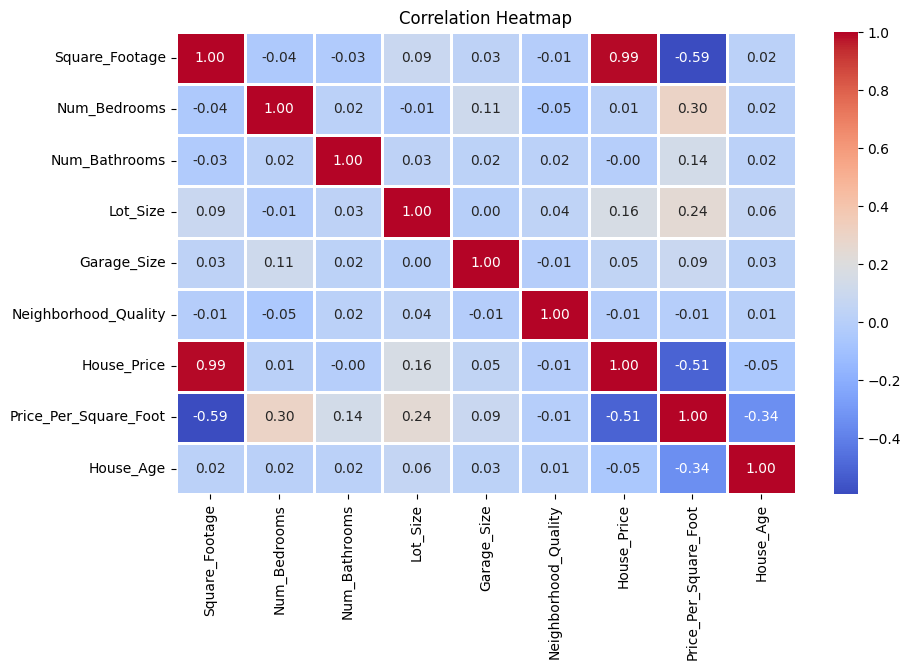

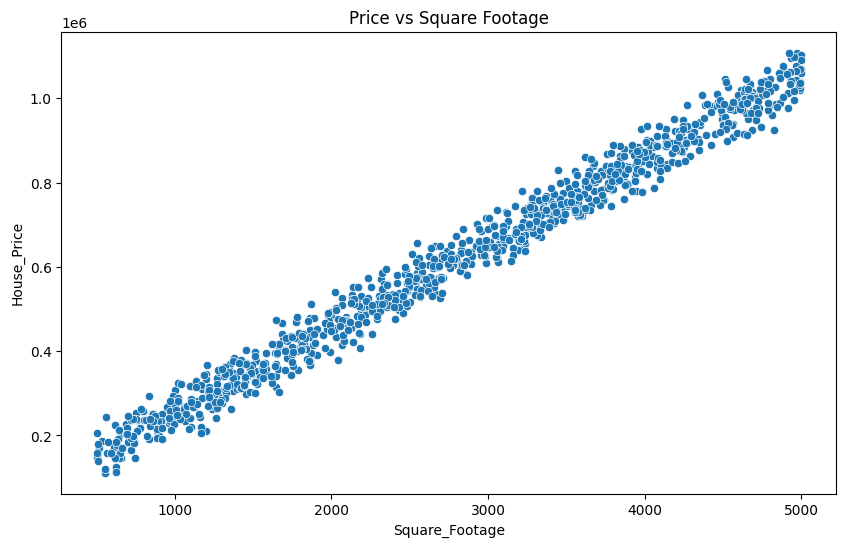

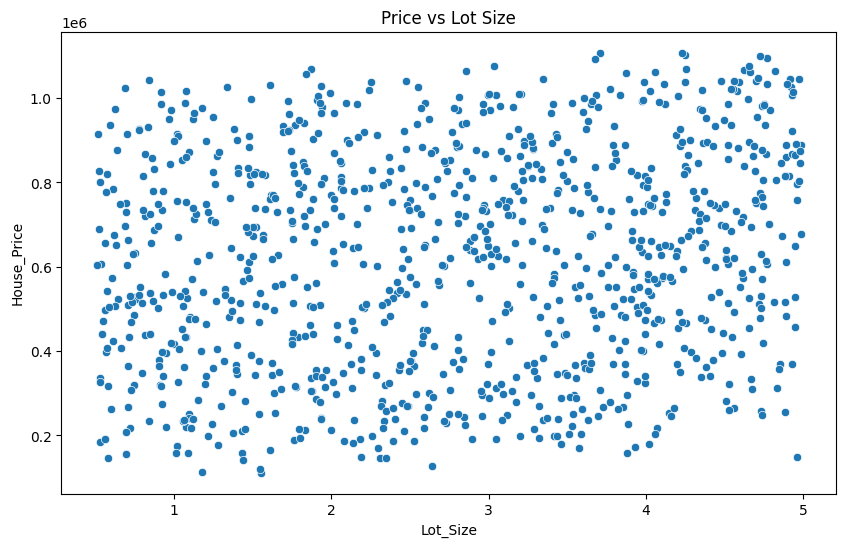

In [9]:
# Create price per square foot and age of house
df['Price_Per_Square_Foot'] = df['House_Price'] / df['Square_Footage']
df['House_Age'] = 2024 - df['Year_Built']

# Drop 'Year_Built' as we no longer need it
df = df.drop(columns=['Year_Built'])

# Perform Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title('Correlation Heatmap')
plt.show()

# Scatter plots for Price vs Square Footage and Price vs Lot Size
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Square_Footage', y='House_Price', data=df)
plt.title('Price vs Square Footage')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Lot_Size', y='House_Price', data=df)
plt.title('Price vs Lot Size')
plt.show()


In [10]:

# Ensure 'House_Price' is the target variable
target_column = 'House_Price'

# Split the data into features and target variable
X = df.drop(columns=[target_column])
y = df[target_column]

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numerical and categorical columns
numerical_features = ['Square_Footage', 'Lot_Size']  # Adjust based on your dataset
categorical_features = ['Neighborhood_Quality']  # Adjust based on your dataset

# Define preprocessors for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Evaluate each model
print("\nModel Evaluation:")
for model_name, model in models.items():
    # Create a pipeline that includes preprocessing and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train the pipeline
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Evaluate the model
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Print evaluation metrics
    print(f"\n{model_name}:")
    print(f"R-squared: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("-" * 50)



Model Evaluation:

Linear Regression:
R-squared: 0.9884
Mean Absolute Error (MAE): 22685.1659
Root Mean Squared Error (RMSE): 27365.9912
--------------------------------------------------

Decision Tree:
R-squared: 0.9742
Mean Absolute Error (MAE): 33174.1571
Root Mean Squared Error (RMSE): 40770.3274
--------------------------------------------------

Random Forest:
R-squared: 0.9858
Mean Absolute Error (MAE): 24317.7495
Root Mean Squared Error (RMSE): 30251.9407
--------------------------------------------------


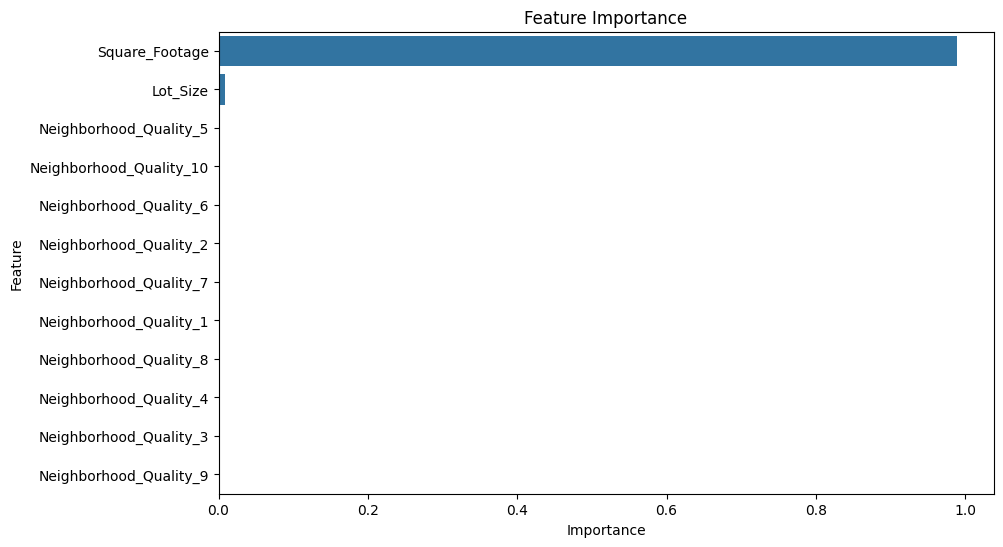

In [11]:
# Feature importance for Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(preprocessor.fit_transform(X_train), y_train)

# Get feature importances
importances = rf_model.feature_importances_
features = numerical_features + list(preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))

# Create a dataframe for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()


In [12]:
def predict_house_price(sqft, lot_size, neighborhood_quality):
    input_data = pd.DataFrame({
        'Square_Footage': [sqft],
        'Lot_Size': [lot_size],
        'Neighborhood_Quality': [neighborhood_quality]
    })
    
    predicted_price = pipeline.predict(input_data)
    return predicted_price[0]

# Example usage:
predicted_price = predict_house_price(1000, 4000, 'ok')
print(f"Predicted House Price: ${predicted_price:,.2f}")


Predicted House Price: $257,092.08
